<a href="https://colab.research.google.com/github/andresni/div/blob/master/IN3050_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IN3050/IN4050 Mandatory Assignment 3: Unsupervised Learning

**Name:** André Sevenius Nilsen

**Username:** andresni

### Importing libraries
We start importing the *numpy* library for performing matrix computations, the *pyplot* library for plotting data, and the *syntheticdata* module to import synthetic data.

**Note:** we'll also add some other imports needed throughout

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import os
import itertools

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Runs import of files for google colab
if not "syntheticdata.py" in [f for f in os.listdir('.') if os.path.isfile(f)]:
  from google.colab import files

  files.upload()

import syntheticdata

####
# Since there are some annoying warnings (future deprecations), I'll plop this little bad boy in
import warnings
warnings.filterwarnings("ignore")

### Centering the Data
Implement a function with the following signature to center the data as explained in *Marsland*.

**Note:** Mean-centering around 0, by column

In [90]:
def center_data(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # X    [NxM] numpy centered data matrix (N samples, M features)

    return A - np.mean(A, axis = 0)

Test your function checking the following assertion on *testcase*:

In [91]:
testcase = np.array([[3.,11.,4.3],[4.,5.,4.3],[5.,17.,4.5],[4,13.,4.4]])
answer = np.array([[-1.,-0.5,-0.075],[0.,-6.5,-0.075],[1.,5.5,0.125],[0.,1.5,0.025]])
np.testing.assert_array_almost_equal(center_data(testcase), answer)

### Computing Covariance Matrix
Implement a function with the following signature to compute the covariance matrix as explained in *Marsland*.

In [92]:
def compute_covariance_matrix(A):
    # INPUT:
    # A    [NxM] centered numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # C    [MxM] numpy covariance matrix (M features, M features)
    #
    # Do not apply centering here. We assume that A is centered before this function is called.
    
    A = A.T # doing transform, rows easier to handle

    # The non-np.cov way
    cov_mat = np.zeros((len(A), len(A))) # size MxM
    
    for i,j in itertools.product(range(len(A)), range(len(A))):
      cov_mat[i,j] = np.sum(A[i] * A[j]) / len(A[0])

    # The np.cov way
    #cov_mat = np.cov(A)
    
    return cov_mat

Test your function checking the following assertion on *testcase*:

In [93]:
testcase = center_data(np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5],[28.,14.,7]]))
answer = np.array([[580.,290.,145.],[290.,145.,72.5],[145.,72.5,36.25]])

# Depending on implementation the scale can be different:
to_test = compute_covariance_matrix(testcase)

answer = answer/answer[0, 0]
to_test = to_test/to_test[0, 0]

np.testing.assert_array_almost_equal(to_test, answer)

### Computing eigenvalues and eigenvectors
Use the linear algebra package of `numpy` and its function `np.linalg.eig()` to compute eigenvalues and eigenvectors. Notice that we take the real part of the eigenvectors and eigenvalues. The covriance matrix *should* be a symmetric matrix, but the actual implementation in `compute_covariance_matrix()` can lead to small round off errors that lead to tiny imaginary additions to the eigenvalues and eigenvectors. These are purely numerical artifacts that we can safely remove.

**Note:** If you decide to NOT use `np.linalg.eig()` you must make sure that the eigenvalues you compute are of unit lenght!

In [94]:
def compute_eigenvalue_eigenvectors(A):
    # INPUT:
    # A    [DxD] numpy matrix
    #
    # OUTPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    
    # Numpy way
    eigval, eigvec = np.linalg.eig(A)
    
    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = eigval.real
    eigvec = eigvec.real
    
    return eigval, eigvec 

Test your function checking the following assertion on *testcase*:

In [95]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([2.,5.,3.])
answer2 = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### Sorting eigenvalues and eigenvectors
Implement a function with the following signature to sort eigenvalues and eigenvectors as explained in *Marsland*.

Remember that eigenvalue *eigval[i]* corresponds to eigenvector *eigvec[:,i]*.

**Note:** see comment in text - this bug threw me for a while

In [96]:
def sort_eigenvalue_eigenvectors(eigval, eigvec, n = 0):
    # INPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    #
    # OUTPUT:
    # sorted_eigval    [D] numpy vector of eigenvalues
    # sorted_eigvec    [DxD] numpy array of eigenvectors
    
    n = len(eigval) if n == 0 else n

    # Interestingly, while eigvals for a covariance matrix
    # should be positive, due to numerical imprecision (probably),
    # we get a sign shift sometimes. Originally, I sorted by absolute eigvals
    # because that is more correct generally speaking as shear length is what matters
    # (although eigvals for cov-mats should always be positive)
    # but in this case, it flipped
    # the signs of of the eigvec and reconstructed matrix
    s_idx = np.argsort(eigval)[::-1][:n]
    
    sorted_eigval = eigval[s_idx]
    sorted_eigvec = eigvec[:, s_idx] # sort column order /i.e. feature order
    
    return sorted_eigval, sorted_eigvec

Test your function checking the following assertion on *testcase*:

In [97]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([5.,3.,2.])
answer2 = np.array([[0.,0.,1.],[1.,0.,0.],[0.,1.,0.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
x,y = sort_eigenvalue_eigenvectors(x,y)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### PCA Algorithm
Implement a function with the following signature to compute PCA as explained in *Marsland* using the functions implemented above.

In [98]:
def pca(A, m = 0): # added 0 for "all"
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # eigval  [Mx1] vector of sorted eigenvalues (this is nice to have later)
    # eigvec    [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
    # P             [Nxm] numpy PCA data matrix (N samples, m features)
    
    A = center_data(A)

    cov_mat = compute_covariance_matrix(A)

    m = len(cov_mat) if m == 0 else m

    eigval, eigvec = compute_eigenvalue_eigenvectors(cov_mat)

    eigval, eigvec = sort_eigenvalue_eigenvectors(eigval, eigvec, m)
    
    P = np.dot(A, eigvec)
    
    return eigval, eigvec, P # Had to remove the .T here to keep dimensionality correct (cov_mat does the .T)

Test your function checking the following assertion on *testcase*:

In [99]:
testcase = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5]])
_, x,y = pca(testcase,2)

answer1_file = open('PCAanswer1.pkl','rb'); answer2_file = open('PCAanswer2.pkl','rb')
answer1 = pkl.load(answer1_file); answer2 = pkl.load(answer2_file)

test_arr_x = np.sum(np.abs(np.abs(x) - np.abs(answer1)), axis=0)
np.testing.assert_array_almost_equal(test_arr_x, np.zeros(2))


test_arr_y = np.sum(np.abs(np.abs(y) - np.abs(answer2)))
np.testing.assert_almost_equal(test_arr_y, 0)

## Understanding: how does PCA work?
We now use the PCA algorithm you implemented on a toy data set in order to understand its inner workings.

### Loading the data
The module *syntheticdata* provides a small synthetic dataset of dimension [100x2] (100 samples, 2 features).

In [100]:
X = syntheticdata.get_synthetic_data1()

### Visualizing the data
Visualize the synthetic data using the function *scatter()* from the *matplotlib* library.

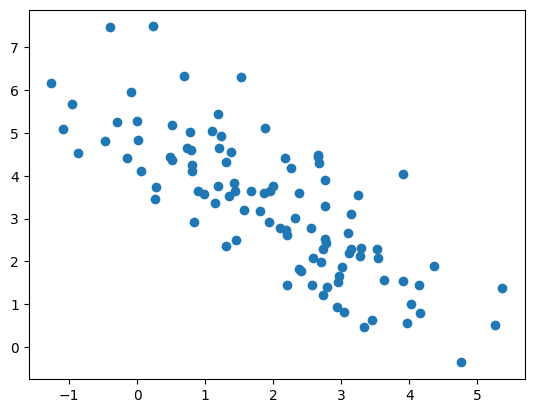

In [101]:
plt.scatter(X[:,0],X[:,1])

### Visualize the centered data
Notice that the data visualized above is not centered on the origin (0,0). Use the function defined above to center the data, and the replot it.

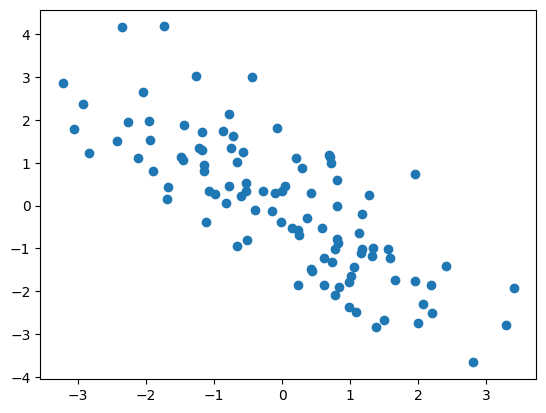

In [102]:
X = center_data(X)
plt.scatter(X[:,0],X[:,1])

### Visualize the first eigenvector
Visualize the vector defined by the first eigenvector.
To do this you need:
- Use the *PCA()* function to recover the eigenvectors
- Plot the centered data as done above 
- The first eigenvector is a 2D vector (x0,y0). This defines a vector with origin in (0,0) and head in (x0,y0). Use the function *plot()* from matplotlib to plot a line over the first eigenvector.

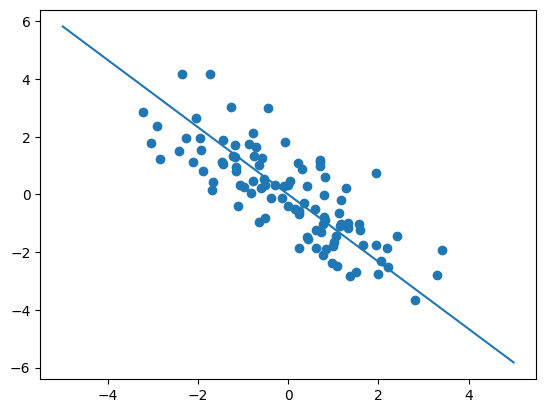

In [103]:
_, eigvec, P = pca(X, 1)

plt.scatter(X[:,0],X[:,1])

x = np.linspace(-5, 5, 1000)
y = eigvec[1]/eigvec[0] * x
plt.plot(x,y)

### Visualize the PCA projection
Finally, use the *PCA()* algorithm to project on a single dimension and visualize the result using again the *scatter()* function.

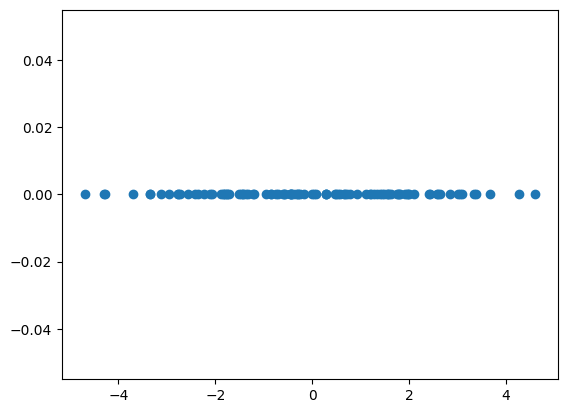

In [104]:
plt.scatter(P,np.zeros((len(P))))

## Evaluation: when are the results of PCA sensible?
So far we have used PCA on synthetic data. Let us now imagine we are using PCA as a pre-processing step before a classification task. This is a common setup with high-dimensional data. We explore when the use of PCA is sensible.

### Loading the first set of labels
The function *get_synthetic_data_with_labels1()* from the module *syntethicdata* provides a first labeled dataset.

In [105]:
X,Y = syntheticdata.get_synthetic_data_with_labels1()

### Running PCA
Process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

Eigenvector (loadings) of the two features in X are: [0.65673055] and [-0.75412531]
Pearsons' r correlation between the two features: -0.93


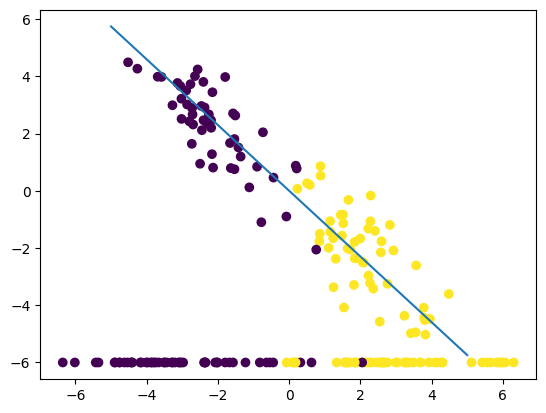

In [106]:
_, eigvec, P = pca(X, 1)

X = center_data(X)

plt.scatter(X[:,0],X[:,1], c = Y[:, 0])

x = np.linspace(-5, 5, 1000)
y = eigvec[1]/eigvec[0] * x
plt.plot(x,y)

plt.scatter(P, np.ones((len(P))) - 7, c = Y[:, 0])

print("Eigenvector (loadings) of the two features in X are: " + str(eigvec[0]) + " and " + str(eigvec[1]))

print("Pearsons' r correlation between the two features: {:.2f}".format(np.corrcoef(X.T)[0, 1]))

**Comment:** The plot above shows the labeled data in original coordinate system, and projected along the first PC (here it's sheared onto the x-axis, so appears stretched). For visualization I put them in the same plot and shifted the y-intercept for the first PC.

It's a pretty good fit, with an obvious seperation at around X = 0.5. The PC plotted here thus represents a linear combination (w1x1 + w2x2, ...) of the different features in X. There are only two features in X, and they load ~.65 and ~-.75 onto the first PC, so both are important for prediciting the shape of the cloud (incidentally, also both are important for seperating the dataset; you can draw a "cross" and use the X-intercept OR the Y-intercept as pretty good thresholds). This is also clear from the original plot as both the features are strongly correlated with each other: r = -.93.

Interesting to note, a single PC is the same as a linear regression line, so PCA with one PC, lin.reg., a perceptron, etc., are all really the same in different dresses, but with different options. It's not something I've really grokked until now.

### Loading the second set of labels
The function *get_synthetic_data_with_labels2()* from the module *syntethicdata* provides a second labeled dataset.

In [107]:
X,Y = syntheticdata.get_synthetic_data_with_labels2()

### Running PCA
As before, process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

Eigenvector (loadings) of the two features in X are: [0.44641118] and [-0.89482795]
Pearsons' r correlation between the two features: -0.36


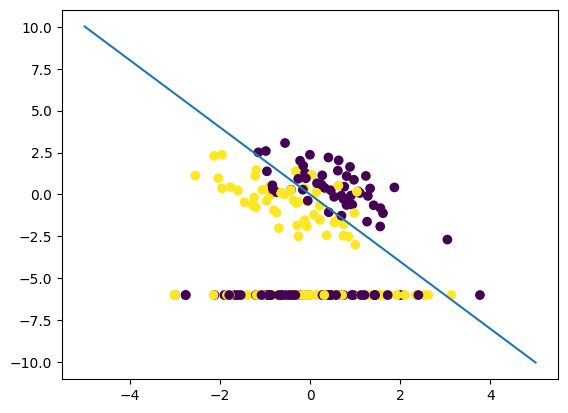

In [108]:
_, eigvec, P = pca(X, 1)

X = center_data(X)

plt.scatter(X[:,0],X[:,1], c = Y[:, 0])

x = np.linspace(-5, 5, 1000)
y = eigvec[1]/eigvec[0] * x
plt.plot(x,y)

plt.scatter(P, np.ones((len(P))) - 7, c = Y[:, 0])

print("Eigenvector (loadings) of the two features in X are: " + str(eigvec[0]) + " and " + str(eigvec[1]))
print("Pearsons' r correlation between the two features: {:.2f}".format(np.corrcoef(X.T)[0, 1]))

**Comment:** While the first PC is overall the same, we can now see that the second feature is loaded much more heavily than the first (twice as much). The two features are also less correlated.

How would the result change if you were to consider the second eigenvector? Or if you were to consider both eigenvectors?

**Answer**: Probably the second PC would be (must be) orthogonal to the first. It'll shear much more than for the previous dataset (easy to visualize), and the variance will thus be bigger. However, in terms of the labels, it's clear that neither PC alone gives amples basis for labeling by themselves or together given the heavily overlapping distributions (unlike in the first dataset).

## Case study 1: PCA for visualization
We now consider the *iris* dataset, a simple collection of data (N=150) describing iris flowers with four (M=4) features. The features are: Sepal Length, Sepal Width, Petal Length and Petal Width. Each sample has a label, identifying each flower as one of 3 possible types of iris: Setosa, Versicolour, and Virginica.

Visualizing a 4-dimensional dataset is impossible; therefore we will use PCA to project our data in 2 dimensions and visualize it.

### Loading the data
The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [109]:
X,Y = syntheticdata.get_iris_data()

### Visualizing the data by selecting features
Try to visualize the data (using label information) by randomly selecting two out of the four features of the data. You may try different pairs of features.

In [110]:
@interact
def diff_feat(f1 = np.arange(len(X[0])), f2 = np.arange(len(X[0]))):
  X,Y = syntheticdata.get_iris_data()

  #a = np.random.choice(len(X[0]), 2, replace = False) # For random gen of which features to plot
  _, eigvec, P = pca(X[:, [f1, f2]], 1)

  X = center_data(X)
  plt.scatter(X[:,f1],X[:,f2], c = Y)

  x = np.linspace(-5, 5, 1000)
  y = eigvec[1]/eigvec[0] * x
  plt.plot(x,y)
  plt.xlabel("Feature " + str(f1)); plt.ylabel("Feature " + str(f2))
  plt.show()
  print("Eigenvector (loadings) of the two features in X are: " + str(eigvec[0]) + " and " + str(eigvec[1]))
  print("Pearsons' r correlation between the two features: {:.2f}".format(np.corrcoef(X.T)[0, 1]))

interactive(children=(Dropdown(description='f1', options=(0, 1, 2, 3), value=0), Dropdown(description='f2', op…

**Note:** Running the above interact function let's you explore the different pairings. For all f1 = 1 pairings however, it's not obviously clear that the first PC is a good fit. For example, the 1-3 pairing. It's obvious that the second feature loads heavily, almost 4 times as much. On the other hand, the orthogonal feature to this one would explain more or less the same.

### Visualizing the data by PCA
Process the data using PCA and visualize it (using label information). Compare with the previous visualization and comment on the results.

In [111]:
@interact
def diff_feat(f1 = np.arange(len(X[0])), f2 = np.arange(len(X[0]))):
  X,Y = syntheticdata.get_iris_data()

  #a = np.random.choice(len(X[0]), 2, replace = False) # For random gen of which features to plot
  _, eigvec, P = pca(X[:, [f1, f2]], 1)

  X = center_data(X)
  plt.scatter(X[:,f1],X[:,f2], c = Y)

  x = np.linspace(-5, 5, 1000)
  y = eigvec[1]/eigvec[0] * x
  plt.plot(x,y)
  plt.xlabel("Feature " + str(f1)); plt.ylabel("Feature " + str(f2))

  plt.scatter(P, np.ones((len(P))) - 7, c = Y)

  plt.show()
  print("Eigenvector (loadings) of the two features in X are: " + str(eigvec[0]) + " and " + str(eigvec[1]))
  print("Pearsons' r correlation between the two features: {:.2f}".format(np.corrcoef(X.T)[0, 1]))

interactive(children=(Dropdown(description='f1', options=(0, 1, 2, 3), value=0), Dropdown(description='f2', op…

**Comment:** When comparing the same "troublesome" PCs when projected down to 1 dim, however, it looks much more reasonable.

## Case study 2: PCA for compression
We now consider the *faces in the wild (lfw)* dataset, a collection of pictures (N=1280) of people. Each pixel in the image is a feature (M=2914).

### Loading the data
The function *get_lfw_data()* from the module *syntethicdata* returns the *lfw* dataset. It returns a data matrix of dimension [1280x2914] and a label vector of dimension [1280]. It also returns two parameters, $h$ and $w$, reporting the height and the width of the images (these parameters are necessary to plot the data samples as images). Beware, it might take some time to download the data. Be patient :) 

In [112]:
X,y,h,w = syntheticdata.get_lfw_data()

### Inspecting the data
Choose one datapoint to visualize (first coordinate of the matrix $X$) and use the function [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to plot and inspect some of the pictures.

Notice that *imshow* receives as a first argument an image to be plot; the image must be provided as a rectangular matrix, therefore we reshape a sample from the matrix $X$ to have height $h$ and width $w$. The parameter *cmap* specifies the color coding; in our case we will visualize the image in black-and-white with different gradations of grey.

In [113]:
@interact
def show_im(X = fixed(X), h = fixed(h), w = fixed(w), image_nr = np.arange(len(X))):
  plt.imshow(X[image_nr,:].reshape((h, w)), cmap=plt.cm.gray)
  plt.show()

interactive(children=(Dropdown(description='image_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

### Implementing a compression-decompression function
Implement a function that first uses PCA to project samples in low-dimensions, and the reconstruct the original image.

*Hint:* Most of the code is the same as the previous PCA() function you implemented. You may want to refer to *Marsland* to check out how reconstruction is performed.

In [114]:
def encode_decode_pca(A,m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    
    _, eigvec, Ahat = pca(A, m)
    
    return np.dot(Ahat, eigvec.T)

### Compressing and decompressing the data
Use the implemented function to encode and decode the data by projecting on a lower dimensional space of dimension 200 (m=200).

In [115]:
Xhat = encode_decode_pca(X, 150) # I did reduction ->150 dim for fun (tried many others too)

### Inspecting the reconstructed data
Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

In [116]:
@interact
def show_im(X = fixed(X), Xhat = fixed(Xhat), h = fixed(h), w = fixed(w), image_nr = np.arange(len(X))):
  plt.subplot(1,2,1)
  plt.imshow(X[image_nr,:].reshape((h, w)), cmap=plt.cm.gray)
  plt.title("Original")
  plt.subplot(1,2,2)
  plt.imshow(Xhat[image_nr,:].reshape((h, w)), cmap=plt.cm.gray)
  plt.title("Reconstructed")
  plt.show()

interactive(children=(Dropdown(description='image_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

**Comment:** It does a remarkable good job of reducing the size of images, although at 100 dims, it's getting a bit blurry. Note to self, when to .T and when not to .T is iffy to me. Sometimes it feels like trial and error, or doing what the math tells me to do but not really grokking when and why transposing a matrix/vector is the right thing to do. Conceptually it makes sense, but in practice, I loose track of which dimensions should be where. Same with when to use matmul, dot, or *, especially for nxm matrices where n=/=m or with 3+ dims.

### Evaluating different compressions
Use the previous setup to generate compressed images using different values of low dimensions in the PCA algorithm (e.g.: 100, 200, 500, 1000). Plot and comment on the results.

**Comment:** I did it manually in the previous section before reading this question. Obviously, more dims = more accurate reconstruction, with some "threshold" around 150-250 dims to my eye at least. If you inspect various images, however, you'll notice that eyes and mouth and nose are generally in the same place for each image, so these are good features to compress by. But, if you look at picture 627 on the interactive above, you can see that for 100 dim reconstruction, the finger (or hand) is more or less gone as that's not a common feature in this imageset.

## Master Students: PCA Tuning
If we use PCA for compression or decompression, it may be not trivial to decide how many dimensions to keep. In this section we review a principled way to decide how many dimensions to keep.

The number of dimensions to keep is the only *hyper-parameter* of PCA. A method designed to decide how many dimensions/eigenvectors is the *proportion of variance*:
$$ \textrm{POV}=\frac{\sum_{i=1}^{m}{\lambda_{i}}}{\sum_{j=1}^{M}{\lambda_{j}}}, $$
where $\lambda$ are eigenvalues, $M$ is the dimensionality of the original data, and $m$ is the chosen lower dimensionality. 

Using the $POV$ formula we may select a number $M$ of dimensions/eigenvalues so that the proportion of variance is, for instance, equal to 95%.

Implement a new PCA for encoding and decoding that receives in input not the number of dimensions for projection, but the amount of proportion of variance to be preserved.

**Note:** I made the original PCA output eigvals (sorted), so we can do stuff like this later :)

In [117]:
def encode_decode_pca_with_pov(A,p):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # p    float number between 0 and 1 denoting the POV to be preserved
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    # m    integer reporting the number of dimensions selected

    eigval, eigvec, Ahat = pca(A, 0) # 0 means all

    # get a cumulative density distribution of explained variance (could use cummulative sum also)
    ps = np.array([np.sum(eigval[:i])/np.sum(eigval) for i in range(len(eigval))]) 

    m = int(np.argwhere(ps > p)[0]) # find first spot where the p-dist > p threshold

    # Plot the scree plot plus cum.variance over features
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(np.arange(len(eigval)), eigval)
    ax2.plot(ps, "k--")
    ax2.plot([m, m], [0, 1.2], ":")
    ax2.text(m*1.2, 1.1, "p={:.2f} at k={} thresh".format(p, m))
    ax1.set_ylabel("Variance")
    ax1.set_yscale("log")
    ax1.set_xlabel("Features")
    ax2.set_ylabel("Prop. explained variance")

    return np.dot(np.dot(A, eigvec[:, :m]), eigvec[:, :m].T), m

Import the *lfw* dataset using the *get_lfw_data()* in *syntheticdata*. Use the implemented function to encode and decode the data by projecting on a lower dimensional space such that POV=0.9. Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

In [118]:
X,y,h,w = syntheticdata.get_lfw_data()

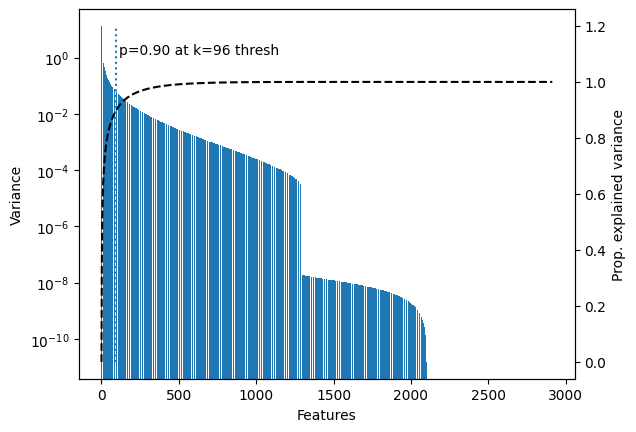

In [119]:
Xhat,m = encode_decode_pca_with_pov(X, 0.9)

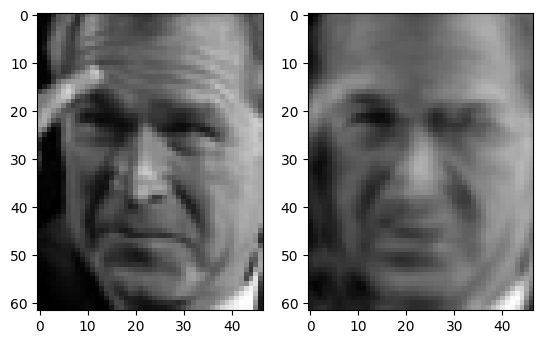

Optimal k = 96


In [120]:
plt.subplot(1,2,1)
plt.imshow(X[627,:].reshape((h, w)), cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(Xhat[627,:].reshape((h, w)), cmap=plt.cm.gray)
plt.show()
print("Optimal k = {}".format(m))

**Comment:** A couple of interesting observations. One is that there's a single PC that is very, very informative. An order of magnitude over that of the next one. If you run with p=0.11 you'll get k=1. The resulting image is a ghostly face outline that I assume is a superimposition of all the faces. A weighted average if you will. A normal average can be seen below. It's not that different from the k=1 PCA.

Secondly, there's a dropoff halway wrt. k in variance. This, I assume, is due to the nr of samples. 

Overall, I'm a bit surprised that the optimal k for p=0.9 is 93 and not closer to my initial guess of 150-250. Even the k=200 image earlier shows some disfigurement. However, it's about explained variance and not our brain's interpretation of accuracy of representation. For that, I expect, we need p>0.95. 

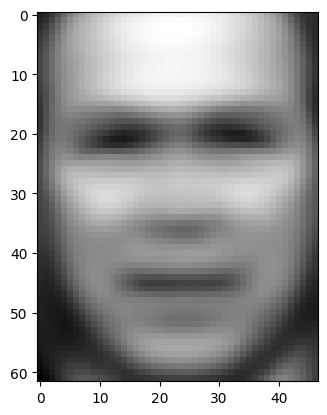

In [121]:
plt.imshow(np.mean(X, axis=0).reshape((h, w)), cmap=plt.cm.gray)

# K-Means Clustering (Bachelor and master students)
In this section you will use the *k-means clustering* algorithm to perform unsupervised clustering. Then you will perform a qualitative assesment of the results.

### Importing scikit-learn library
We start importing the module *cluster.KMeans* from the standard machine learning library *scikit-learn*.

In [122]:
from sklearn.cluster import KMeans

### Loading the data
We will use once again the *iris* data set. The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [123]:
X,y = syntheticdata.get_iris_data()

### Projecting the data using PCA
To allow for visualization, we project our data in two dimensions as we did previously. This step is not necessary, and we may want to try to use *k-means* later without the PCA pre-processing. However, we use PCA, as this will allow for an easy visualization.

In [124]:
_,_,P = pca(X, 2)

### Running k-means
We will now consider the *iris* data set as an unlabeled set, and perform clustering to this unlabeled set. We can compare the results of the clustering to the lableled calsses.

Use the class *KMeans* to fit and predict the output of the *k-means* algorithm on the projected data. Run the algorithm using the following values of $k=\{2,3,4,5\}$. 

### Qualitative assessment
Plot the results of running the k-means algorithm, compare with the true labels, and comment.

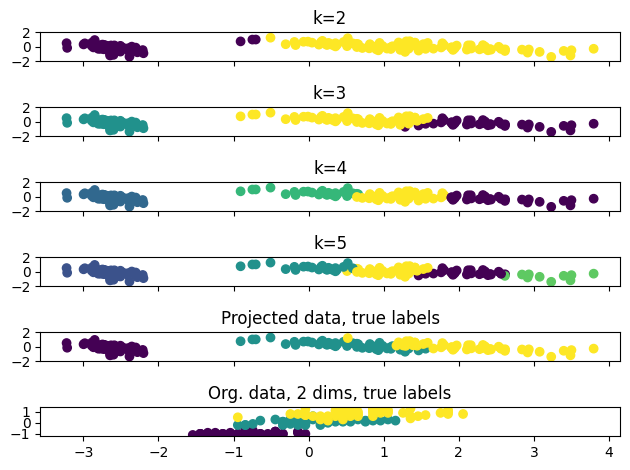

In [125]:
fig, ax = plt.subplots(6,1,sharex=True)
for i, k in enumerate([2,3,4,5]):
  KM = KMeans(k)
  yhat2 = KM.fit_predict(P)
  
  ax[i].scatter(P[:,0],P[:,1],c=yhat2)
  ax[i].set_title('k={}'.format(k))
  ax[i].set_ylim([-2, 2])
ax[4].scatter(P[:,0],P[:,1],c=y)
ax[4].set_title('Projected data, true labels')
ax[4].set_ylim([-2, 2])
ax[5].scatter(center_data(X)[:,0],center_data(X)[:,3],c=y)
ax[5].set_title('Org. data, 2 dims, true labels')
fig.tight_layout()

**Comment:** K-means finds some natural groups (at least the leftmost one/dark blue in org data), and does a pretty decent job at it compared to projected data for k=3. Distance metrics/clustering metrics would pop out at k=2 (most likely) for the projected data, and depending on how the 4d org. set really is (hard to visuialize), might be pretty accurate on the original dataset.

Projecting down to two dimensions might be too little here, though. As seen earlier when comparing which two features to project down from, feature 1 (#2) gave worse fits than the others, which could indicate that m=3 might be a good start.

# Quantitative Assessment of K-Means (Bachelor and master students)

We used k-means for clustering and we assessed the results qualitatively by visualizing them. However, we often want to be able to measure in a quantitative way how good the clustering was. To do this, we will use a classification task to evaluate numerically the goodness of the representation learned via k-means.

Reload the *iris* dataset. Import a standard `LogisticRegression` classifier from the module `sklearn.linear_model`. Use the k-means representations learned previously (`yhat2,...,yhat5`) and the true label to train the classifier. Evaluate your model on the training data (we do not have a test set, so this procedure will assess the model fit instead of generalization) using the `accuracy_score()` function from the *sklearn.metrics* module. Plot a graph showing how the accuracy score varies when changing the value of k. Comment on the results.

- Train a Logistic regression model using the first two dimensions of the PCA of the iris data set as input, and the true classes as targets.
- Report the model fit/accuracy on the training set.
- For each value of K:
  - One-Hot-Encode the classes output by the K-means algorithm.
  - Train a Logistic regression model on the K-means classes as input vs the real classes as targets.
  - Calculate model fit/accuracy vs. value of K.
- Plot your results in a graph and comment on the K-means fit.

**Note:** I interpret the above as
1. fit the two best PCs (dim.reduction) to the true labels of the IRIS set. Report accuracy of the model vs true labels.
2. Then, for each k, where k is how many clusters the kmeans algorithm should find, fit the found cluster labels (with OHE) to the true labels. Report accuracy of the model vs true labels. (it says vs. value of k, which doesn't make sense)

In essence, by using the k-means clusters as inputs, the question is how well can these cluster labels predict the true labels?

Accuracy for 2 PCs, vs. true labels (OHE):
3 classes, accuracy: 0.97%



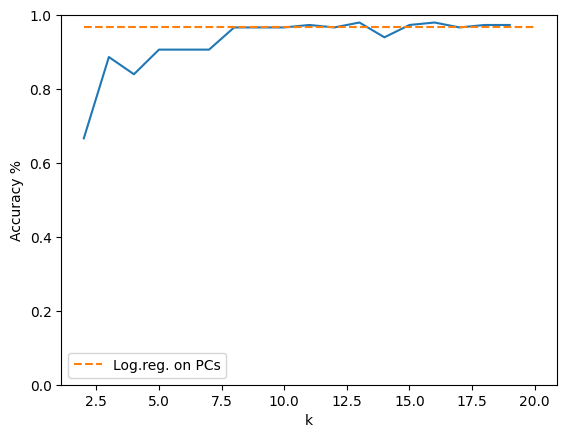

In [126]:
def one_hot_encode(y):
  """ Takes vector size n and returns nxm where m = number of classes"""
  classes = len(np.unique(y)) # nr of labels to one-hot encode
  a = np.zeros((len(y), classes)) # set the shape of desired output
  for i in np.arange(len(y)): 
    a[i, y[i]] = 1

  return a

def one_hot_decode(y_):
  """ Takes a one-hot encoded matrix and returns a vector 
      Uses max probability decoding"""
  return [np.argmax(i) for i in y_]

logreg = LogisticRegression(multi_class = "multinomial") # Each fit call resets the model

# For the two best PCs + real labels
logreg.fit(P, y)
pred_class = one_hot_decode(logreg.predict_proba(P)) # Need to decode too / or use .predict - same same
print("""Accuracy for 2 PCs, vs. true labels (OHE):
{} classes, accuracy: {:.2f}%
""".format(len(np.unique(y)), metrics.accuracy_score(y, pred_class))) # Or just .score - same same

# For the kmeans found classes, for each k
accuracies = []

for i, k in enumerate(np.arange(2,20)):
  KM = KMeans(k)
  yhat2 = KM.fit_predict(P)
  logreg.fit(one_hot_encode(yhat2), y)
  scores = one_hot_decode(logreg.predict_proba(one_hot_encode(yhat2))) # could also use .predict
  accuracies.append(metrics.accuracy_score(y, scores)) # could also use the score parameter in logreg
  #print("""Accuracy for 2 PCs, vs. kmeans labels (OHE):
  #k={}, accuracy: {:.2f}%
  #""".format(k, accuracies[-1]))

plt.plot(np.arange(2,20), accuracies)
plt.plot([2,20], [metrics.accuracy_score(y, pred_class)]*2, "--", label = "Log.reg. on PCs")
plt.ylim([0,1])
plt.ylabel("Accuracy %")
plt.xlabel("k")
plt.legend()

**Comment:** The first attempt at doing this task can only be summarized as - not really working. Or, if this is as intended - it works but logistic regression using k-means clusters as input vectors is not a good idea for this data set at least.

The default parameters for the log.reg. function should suffice for the dataset. L2 penalty and lbfgs solver should work fine given the problem at hand, although lbfgs is not optimal for all OHE datasets, we should be fine given non-rare classes.

Thus, if the above approach is correctly implemented, and I cannot see that it is not, then the k-means clustering does not do a good job vis-a-vis the original data labels.

***

I did however, find the bug eventually (looping over nr of classes not samples in the OHE function). Out of curiosity, I pasted the code into GPT-4* to see if it could pick up the error.

.

.

.

.

.

.

It did.

**GPT-4 has not been used in this assignment, except for curiosity in how it would implement the code I've already written. In most cases, it's not that far off (or rather, I'm not that far off because, let's be honest, it does a damn good job at it).*

***
Revised observation: Logistic regression on the PCA reduced dataset works very well, to be expected. The k-means fed logistic regression also works well, although it needs qutie many more classes to work with than in the original dataset. As it's working on binarized OHE vectors rather than floating point coordinates (features), it probably requires more data to work with as binarization leads to less "sensitive" data.

Also, I assume that the PCA reduced feature set is what is to be used in the kmeans algorithm, but using the original dataset raw does not change the results much. In a sense, one can question whether PCA dimension reduction is needed in this case.

In terms of the usefulness of the kmeans approach, we can say that, yes, it detects valid clusters for predicting the true labels, but, it needs more clusters than are in the original dataset. And accuracy, while peaking at higher levels than applying logistic regression to the PCA reduced set, it's not a given as it fluctuates around that optima. Comparing applying logistic regression or kmeans to the raw dataset (without running PCA), we get overall the same results. This puts into question the usefulness of running PCA at least on this set.

Finally, while kmeans with k=3 does have a little local maxima bump on the plot above, it might not be accurate enough for most cases. So if you only know the number of clusters in a dataset, but not which they are - kmeans alone is not sufficient to find them (depending on the dataset). Without true labels, it's hard to know for sure.

I would implement some distance metrics here to evaluate the clusters found by the k-means, for example centroid l2 distance relative to mean intracluster distance, similar to stuff like the Dunn Index.

# Conclusions 

In this notebook we studied **unsupervised learning** considering two important and representative algorithms: **PCA** and **k-means**.

First, we implemented the PCA algorithm step by step; we then run the algorithm on synthetic data in order to see its working and evaluate when it may make sense to use it and when not. We then considered two typical uses of PCA: for **visualization** on the *iris* dataset, and for **compression-decompression** on the *lfw* dateset.

We then moved to consider the k-means algorithm. In this case we used the implementation provided by *scikit-learn* and we applied it to another prototypical unsupervised learning problem: **clustering**; we used *k-means* to process the *iris* dataset and we evaluated the results visually.

In the final part, we considered two additional questions that may arise when using the above algorithms. For PCA, we considered the problem of **selection of hyper-parameters**, that is, how we can select the hyper-parameter of ou algorithm in a reasonable fashion. For k-means, we considered the problem of the **quantitative evaluation** of our results, that is, how can we measure the performance or usefulness of our algorithms. 

In [ ]:
# Code for converting to html (and then later to pdf)
#%%shell
#jupyter nbconvert --allow-chromium-download --to html /content/IN3050_assignment_3_test.ipynb
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('IN3050_assignment_3.ipynb')